# Tutorial: optimisation of hodoscopes

We start by defining our volume, composed of a passive volume block and 2 hodoscopes placed above and below the passive volume.
The hodoscope placed above will be initially shifted off-center w.r.t the passive volume, while the hodoscope below will be centered.
This allows us to qualitatively assess the performance of optimisation: does it lead to centered hodoscopes?

First, we import the required modules:


In [1]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from torch import Tensor, nn 
import torch
from tomopt.core import DEVICE
from tomopt.volume.layer import PassiveLayer 
from tomopt.volume import Volume
from torch import autograd

## Creating the volume

We set the initial xyz spans and gaps. Maximum efficiency and resolution values are set for hodoscopes.
These parameters are fixed during the optimisation.


In [2]:
init_xyz_span, xyz_gap = [1.5, 1.5, .3], [.1, .1, .1]
init_eff, init_res = 0.90, 1e3

We define the hodoscopes as `Hodoscope` objects, starting with initial xyz positions, and the fixed values defined above. These hodoscopes are fed as a list to the hodoscope layers placed above/below the passive volume.
Hodoscope layers are instances of the `HodoscopeDetectorLayer` class. 


In [3]:
hod_above = [Hodoscope(init_xyz= [0., 0., 1.2], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                      ) ]


hod_below = [Hodoscope(init_xyz= [0.5, 0.5, 0.], 
                    init_xyz_span = init_xyz_span, 
                    xyz_gap = xyz_gap, 
                    eff = init_eff,
                    res = init_res
                    ) ]

hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                            lw = Tensor([2,2]), 
                                            z = 2., size = 1., 
                                            hodoscopes = hod_above)


hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                            lw = Tensor([2,2]), 
                                            z = .2, size = 1., 
                                            hodoscopes = hod_below)

The `get_layers` function defined below takes as input a list of the hodoscope layers, and returns an nn.ModuleList of the volume. It sandwiches a passive volume between the 2 hodoscope layers.

In [4]:
def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)


To have our volume as a `Volume` object:

In [5]:
volume = Volume(get_layers([hod_detector_above, hod_detector_below]))

Now we plot the volume, in 2D and 3D:

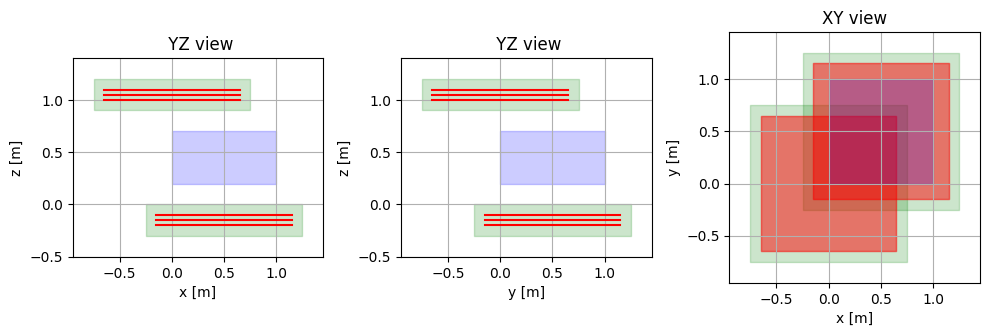

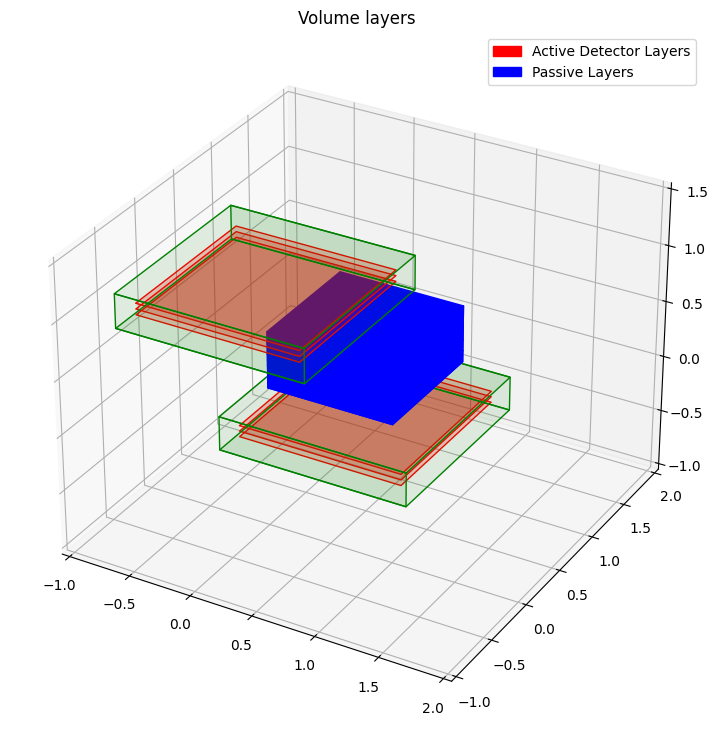

In [6]:
from plotting.plotting import draw_volume_2D, draw
draw_volume_2D(volume)
draw(volume, [-1.,2.], [-1., 2.], [-1.,1.5])

## Optimisation example

We define a wrapper for our volume

In [7]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume

from tomopt.core import X0
from torch import Tensor

from functools import partial
from tomopt.optimisation import VoxelX0Loss

from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

We will also define a `PassiveYielder` object which contains the different passive volume layouts to be used during training. A volume layout is defined with a function similar to the `arb_rad_length` below, which assigns the voxel-wise radiation length of the passive volume.

In [8]:
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

Necessary callback modules are imported. We use our modified implementations for `MetricLogger` and `NoMoreNaNs` 

In [9]:
from tomopt.optimisation import CostCoefWarmup, OptConfig, MuonResampler
from optimisation.hodoscope_callbacks import HodoscopeMetricLogger, NoMoreNaNs

Now we run the optimisation

2 warmup callbacks found, with a total warmup period of 2 epochs.


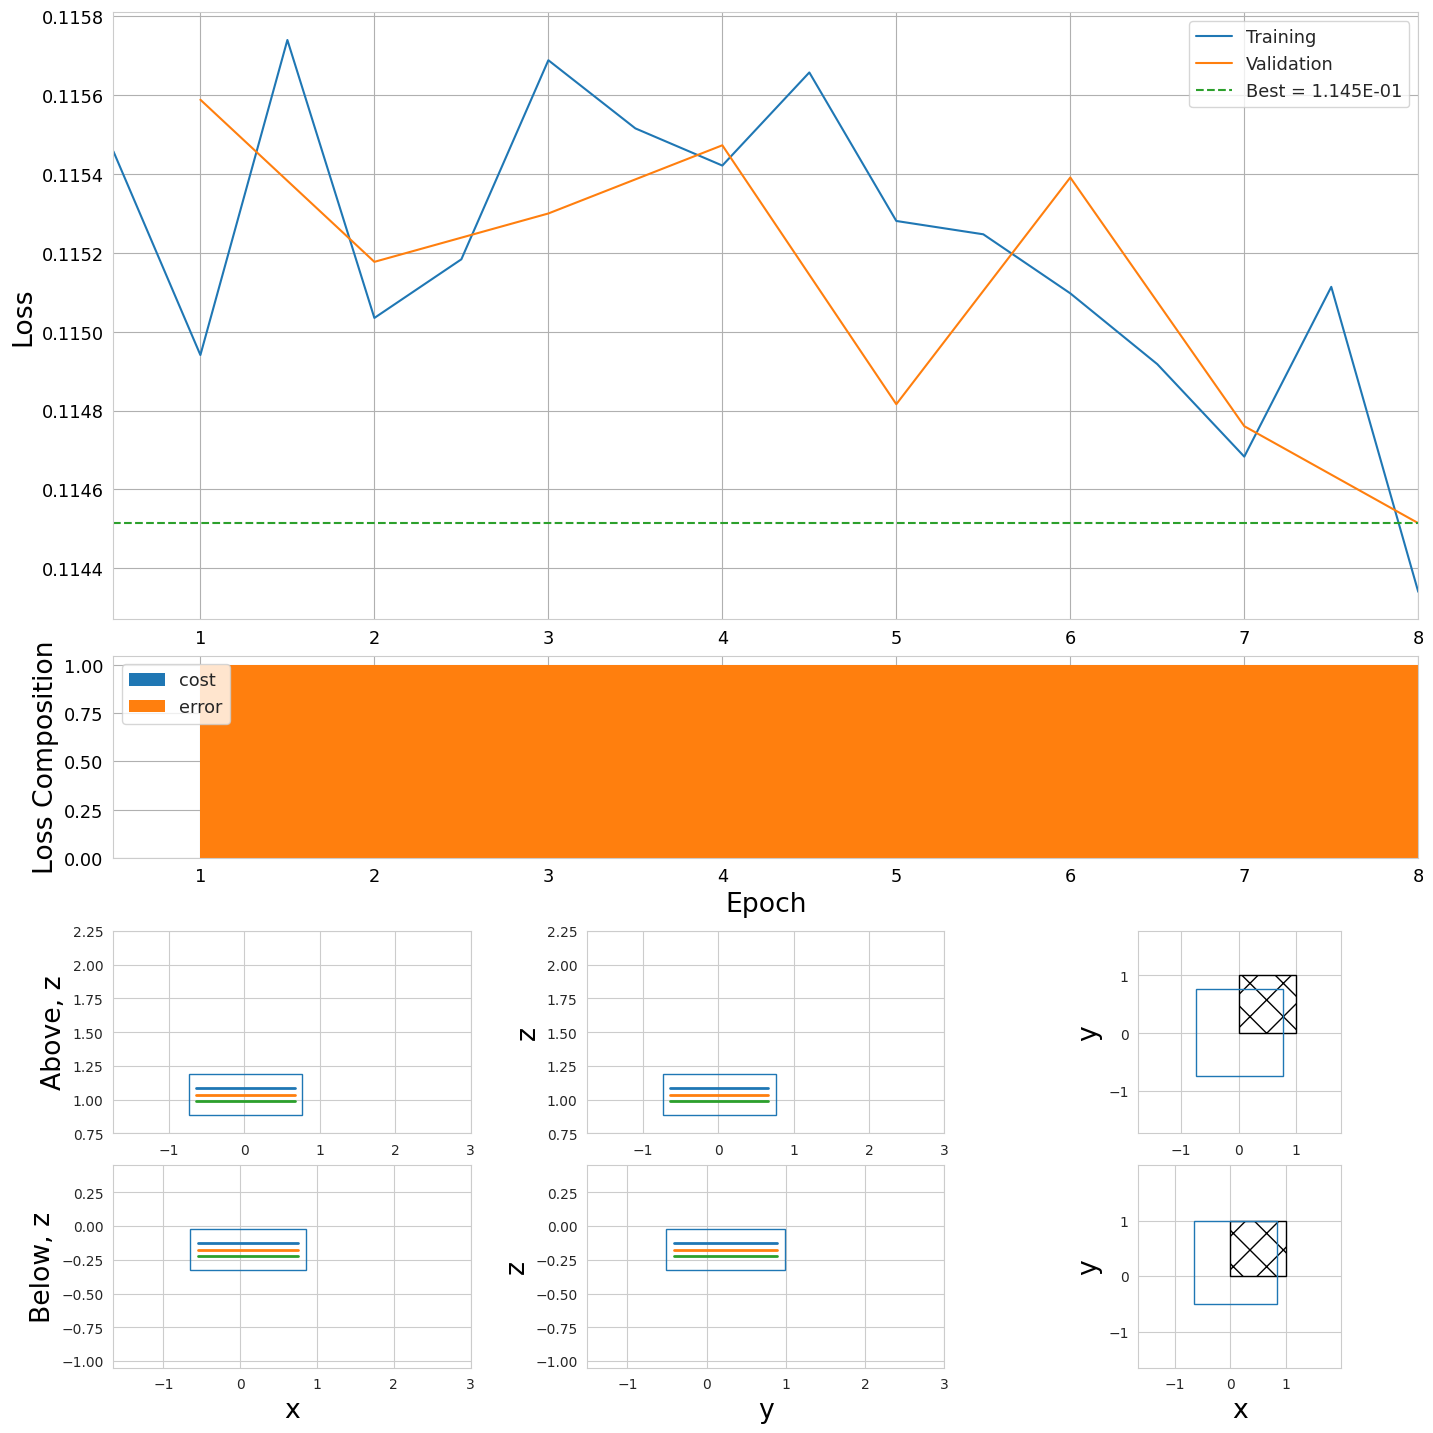

In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
Automatically setting cost coefficient to 0.11544663459062576
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muons removed =  0
In ScatterBATCH filter scatter
 n muo

KeyboardInterrupt: 

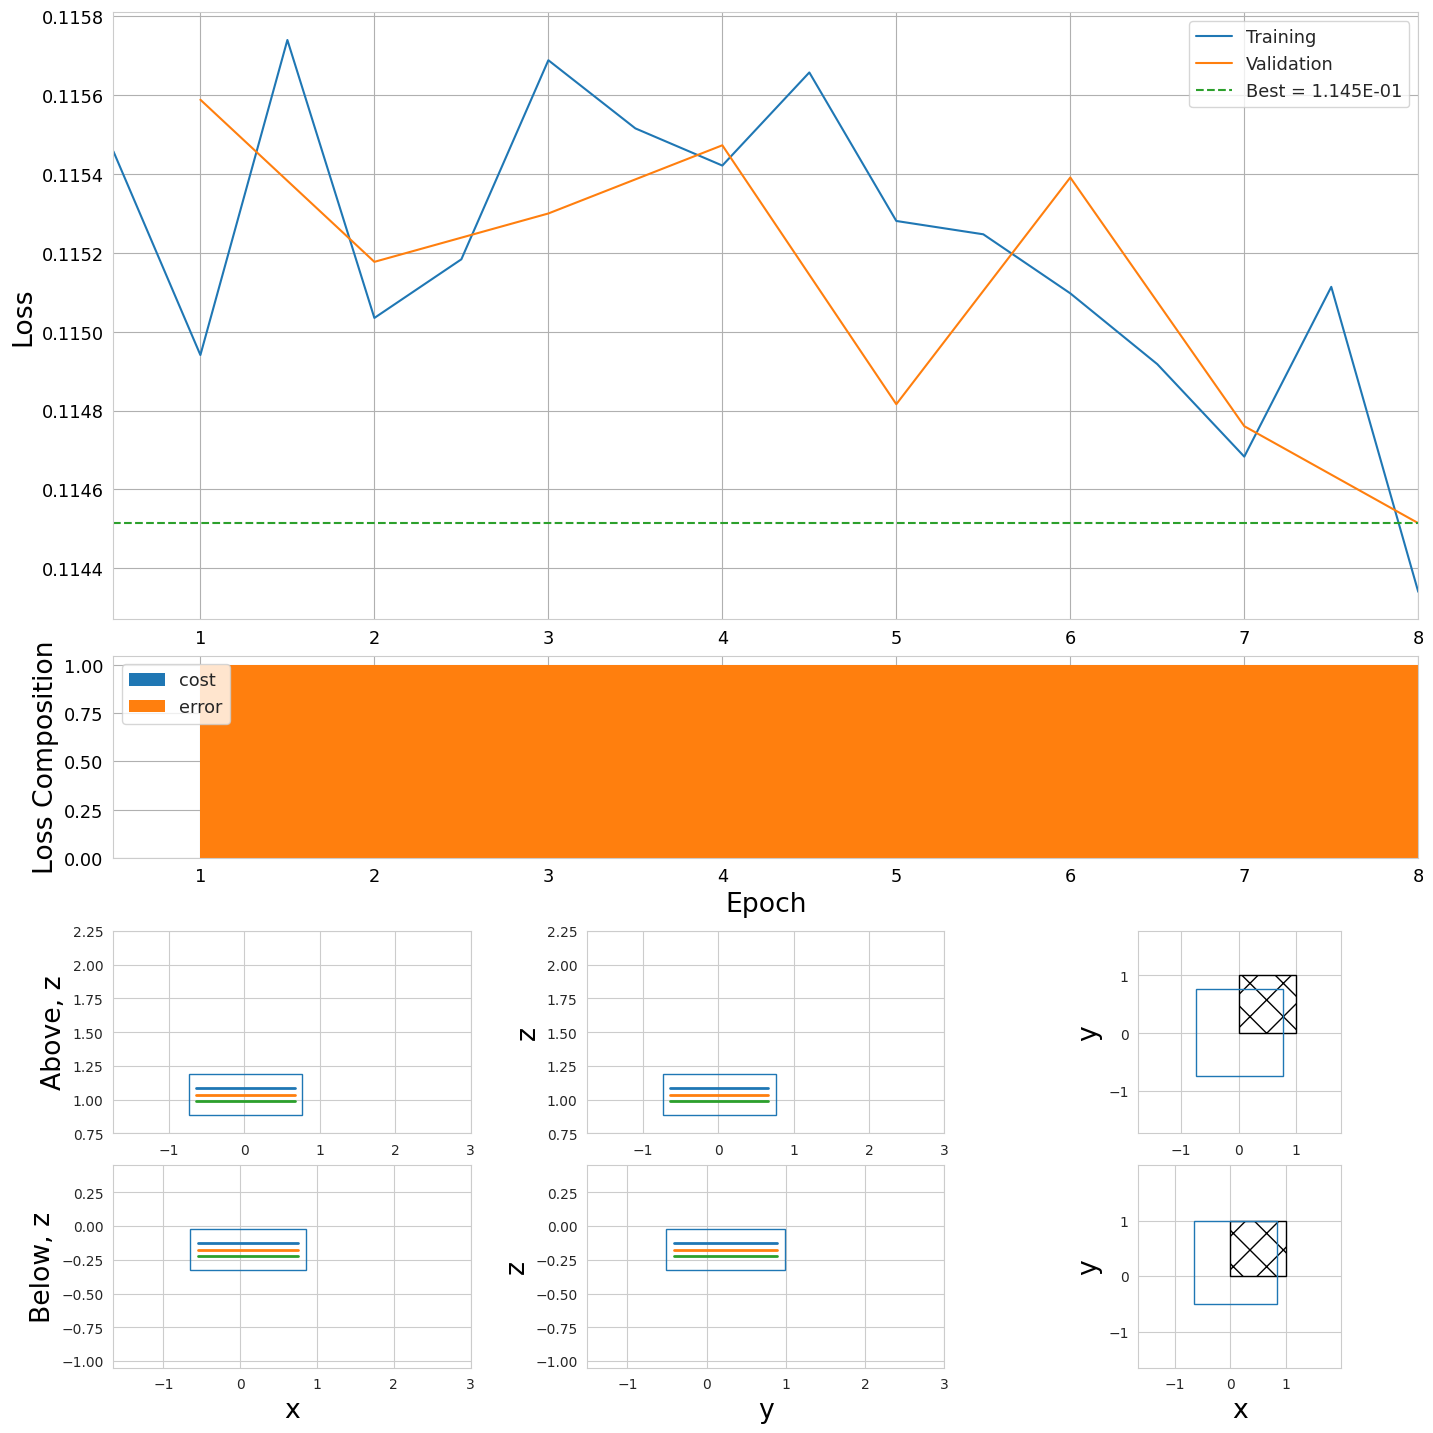

In [10]:
_ = wrapper.fit(n_epochs=20,
                passive_bs=1, 
                n_mu_per_volume=1000, 
                mu_bs=100, 
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=1), OptConfig(n_warmup=1, rates={'xy_pos_opt':0.01, 'z_pos_opt':0.005}), MuonResampler(), NoMoreNaNs(),HodoscopeMetricLogger()])

We notice that the initially centered hodoscope below has been shifted towards the off-centered hodoscope above. Whereas an optimised outcome would be the other way around!

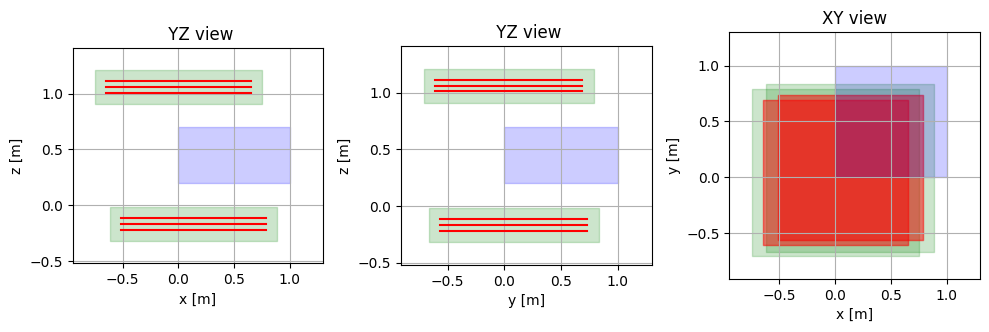

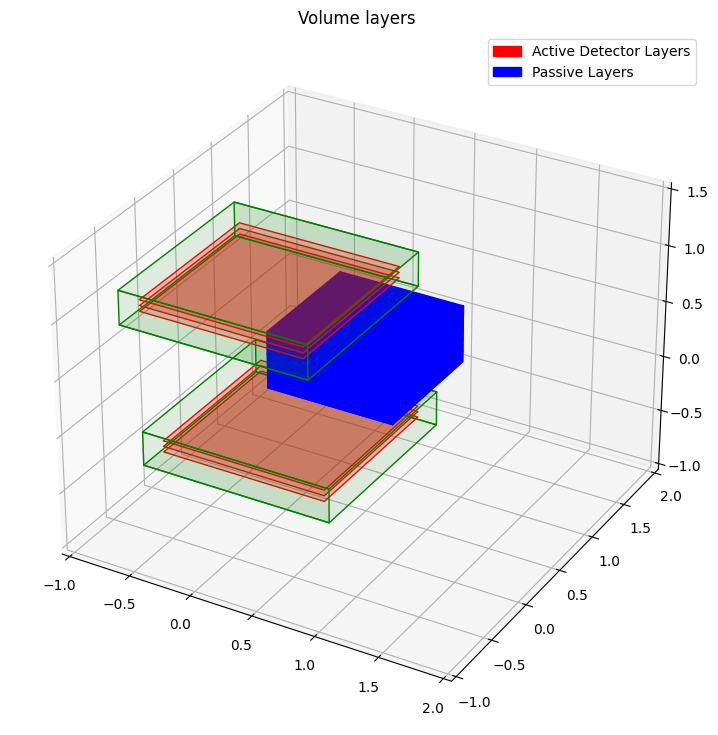

In [ ]:
draw_volume_2D(volume)
draw(volume, [-1.,2.], [-1., 2.], [-1.,1.5])